## 통계 기반 기법
### 파이썬으로 말뭉치 전처리하기

In [2]:
text = 'You say goodbye and I say hello.'

In [3]:
test = text.lower()
text = text.replace('.', ' .')
text

'You say goodbye and I say hello .'

In [4]:
words = text.split(' ')
words

['You', 'say', 'goodbye', 'and', 'I', 'say', 'hello', '.']

* 정규표현식으로 분할하는 방법

In [5]:
import re
words_from_reg = re.split('(\W+)?', text)
words_from_reg

/Users/daeyoung/tensorflow/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


['You',
 ' ',
 'say',
 ' ',
 'goodbye',
 ' ',
 'and',
 ' ',
 'I',
 ' ',
 'say',
 ' ',
 'hello',
 ' .',
 '']

단어 ID와 단어를 짝지어주는 대응표 만들기

In [6]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [8]:
print(id_to_word)
print(word_to_id)

{0: 'You', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'I', 5: 'hello', 6: '.'}
{'You': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'I': 4, 'hello': 5, '.': 6}


단어 목록을 단어 ID 목록으로 변경하기

In [9]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

위 과정을 하나의 함수로 만들기

In [15]:
# common/util.py
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [16]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


### 동시발생 행렬
동시발생 행렬(co-occurrence matrix) 만들기

In [17]:
# common/util.py
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_dix = idx + 1
            
            if leff_idx >= 0 :
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

### 벡터 간 유사도
코사인 유사도(cosine similarity)
$$
similarity(x,y)= {{x \cdot y} \over{\lVert x \rVert \lVert y \rVert}}= {{x_1y_1+...+x_ny_n} \over {\sqrt{x_1^2+...+x_n^2}}{\sqrt{y_1^2+...+y_n^2}}}
$$

In [18]:
def cos_similarity(x, y):
    nx = x / np.sqrt(np.sum(x**2)) # x의 정규화
    ny = y / np.sqrt(np.sum(y**2)) # y의 정규화
    return np.dot(nx, ny)

In [19]:
# handling divide by zero error
# common/util.py
def cos_similarity(x, y, eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    return np.dot(nx, ny)

단어 벡터의 유사도 구하기

In [21]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']] # "you"의 단어 벡터
c1 = C[word_to_id['i']]   # "i"의 단어 벡터
print(cos_similarity(c0, c1))

0.7071067691154799


### 유사 단어의 랭킹 표시

In [24]:
# common/util.py
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 검색어를 꺼낸다.
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    # 코사인 유사도 기준 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

In [25]:
most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## 통계 기반 기법 개선하기
### 상호정보량  
점별 상호정보량(Pointwise Mutual Information, PMI)
$$
PMI(x,y)=\log_2{P(x,y)\over{P(x)P(y)}}
$$
(여기서 P(x),P(y)는 x,y가 각각 발생할 확률을 의미하고, P(x,y)는 x,y가 동시에 발생할 확률을 의미함)  

동시발생 행렬 적용하기
$$
PMI(x,y)=\log_2{P(x,y)\over{P(x)P(y)}}=\log_2{{C(x,y)\over N} \over {{C(x)C(y)}\over{N N}}} = \log_2{{C(x,y) \cdot N}\over {C(x)C(y)}}
$$
(여기서 C는 동시발생 행렬, C(x,y)는 단어 x, y가 동시에 발생하는 횟수, C(x),C(y)는 각각 단어 x,y의 등장 횟수를 의미함)  

하지만 두 단어의 동시발생 횟수가 0이면
$$\log_2{0}=-\infty$$
이 되어서 실제로는 양의 상호정보량(PPMI)을 사용한다.
$$PPMI(x,y)=max(0,PMI(x,y)$$

In [54]:
# common/util.py
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//10) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

In [31]:
text = '툭 웃음이 터지면 그건 너 쿵 내려앉으면은 그건 너 축 머금고 있다면 그건 너 둥 울림이 생긴다면 그건 너'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=2) # 유효 자릿수를 두 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 4 0 1 0 0 1 0 0 1]
 [0 0 0 4 0 1 0 1 0 0 1 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 1 0 0 0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.   4.17 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [4.17 0.   3.17 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   3.17 0.   1.17 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.17 0.   1.36 0.   1.17 0.   0.   1.17 0.   0.   1.17]
 [0.   0.   0.   1.36 0.   1.36 0.   1.36 0.   0.   1.36 0.   0.  ]
 [0.   0.   0.   0.   1.36 0.   3.17 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.17 0.   3.17 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.36 0.   0.   0.   3.17 0.   0.   0.   0.  ]
 [0.   0.   0.

### SVD에 의한 차원 감소

In [32]:
# SVD
U, S, V = np.linalg.svd(W)

print(C[0]) # 동시발생 행렬
print(W[0]) # PPMI 행렬
print(U[0]) # SVD

[0 1 0 0 0 0 0 0 0 0 0 0 0]
[0.   4.17 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
[-4.78e-01 -5.39e-01 -2.78e-01 -6.17e-02 -1.06e-15  3.05e-16 -1.30e-01
  5.72e-02 -1.45e-01 -2.05e-01 -2.70e-01  4.93e-01 -5.55e-17]


In [33]:
print(U[0, :2]) # 2차원 벡터로 축소

[-0.48 -0.54]


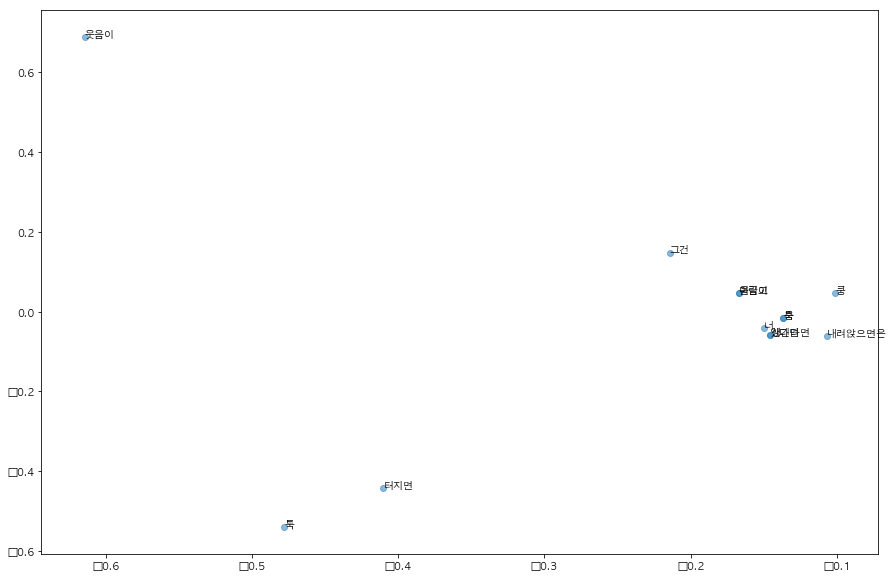

In [39]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_fname = '/Library/Fonts/AppleGothic.ttf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

plt.figure(figsize=(15,10))

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:,0], U[:,1], alpha=0.5)

### PTB 데이터셋

In [41]:
import sys
sys.path.append('..')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:" ,word_to_id['car'])
print("word_to_id['happy']:" ,word_to_id['happy'])
print("word_to_id['lexus']:" ,word_to_id['lexus'])

말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


### PTB 데이터셋 평가

In [56]:
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose=True)

print('SVD 계산 ...')
try:
    # truncated SVD (빠르다)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
    
except ImportError:
    # SVD (느리다)
    U, S, V = np.linalg.svd(W)
    
word_vecs = U[:, :wordvec_size]

queries = ['you', 'year', 'car', 'toyota']
for query in queries:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시발생 수 계산 ...
PPMI 계산 ...
10.0% 완료
20.0% 완료
30.0% 완료
40.0% 완료
50.0% 완료
60.0% 완료
70.0% 완료
80.0% 완료
90.0% 완료
100.0% 완료
SVD 계산 ...

[query] you
 i: 0.7420221567153931
 we: 0.7027932405471802
 anybody: 0.5854558348655701
 'll: 0.5488571524620056
 do: 0.5131361484527588

[query] year
 month: 0.7226830124855042
 quarter: 0.6582736968994141
 next: 0.6340628862380981
 third: 0.6034742593765259
 earlier: 0.5901473760604858

[query] car
 luxury: 0.6331198215484619
 auto: 0.6315429210662842
 corsica: 0.5436363220214844
 rental: 0.49471670389175415
 cars: 0.44343215227127075

[query] toyota
 motor: 0.722671627998352
 motors: 0.6867570281028748
 lexus: 0.6237738132476807
 nissan: 0.6056551933288574
 honda: 0.6000374555587769


#### 이번 장에서 배운 내용
* WordNet 등의 시소러스를 이용하면 유의어를 얻거나 단어 사이의 유사도를 측정하는 등 유용한 작업을 할 수 있다.
* 시소러스 기반 기법은 시소러스를 작성하는 데 엄청난 인적 자원이 든다거나 새로운 단어에 대응하기 어렵다는 문제가 있다.
* 현재는 말뭉치를 이용해 단어를 벡터화하는 방식이 주로 쓰인다.
* 최근의 단어 벡터화 기법들은 대부분 '단어의 의미는 주변 단어에 의해 형성된다'는 분포 가설에 기초한다.
* 통계 기반 기법은 말뭉치 안의 각 단어에 대해서 그 단어의 주변 단어의 빈도를 집계한다(동시발생 행렬).
* 동시발생 행렬을 PPMI 행렬로 변환하고 다시 차원을 감소시킴으로써, 거대한 '희소벡터'를 작은 '밀집벡터'로 변환할 수 있다.
* 단어의 벡터 공간에서는 의미가 가까운 단어는 그 거리도 가까울 것으로 기대된다.